In [49]:
# Parameters

#file_path = 'data/PPG2 18.04.2024 at 11:05.bin'
file_path = 'data/PPG2 18.04.2024 at 15:35.bin'
#file_path = 'data/PPG2 18.04.2024 at 16:35.bin'


samples_to_strip = 15 * 30  # 15 seconds * 30 Hz
sample_amount = 30 * 30 # 20 seconds * 30 Hz

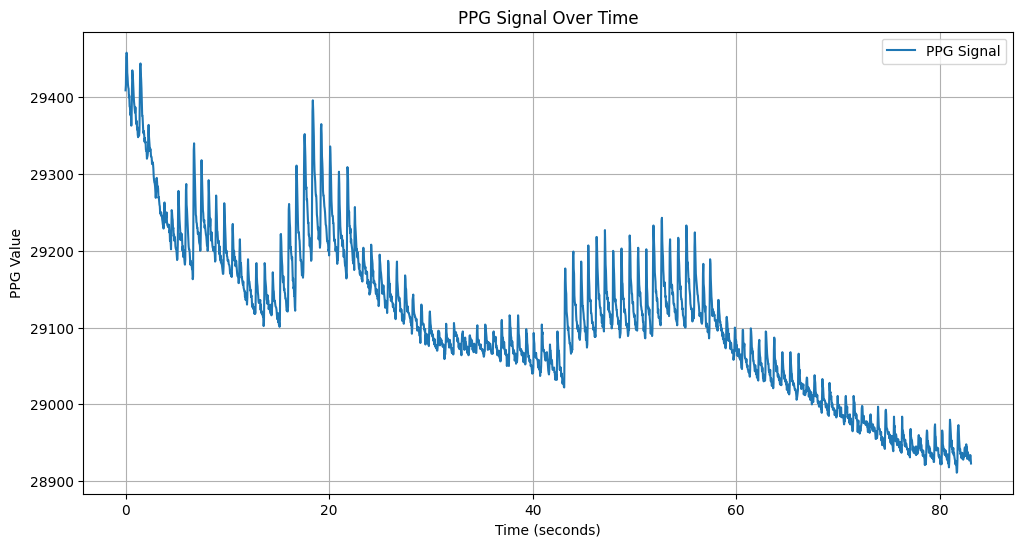

In [50]:
import numpy as np
import matplotlib.pyplot as plt

## TODO: why is the data negative?
data = -np.fromfile(file_path, dtype=np.uint16)

# Create a time axis in seconds (data sampled at 30 Hz)
time = np.arange(len(data)) / 30.0

# Plot the PPG data
plt.figure(figsize=(12, 6))
plt.plot(time, data, label='PPG Signal')
plt.xlabel('Time (seconds)')
plt.ylabel('PPG Value')
plt.title('PPG Signal Over Time')
plt.legend()
plt.grid(True)
plt.show()

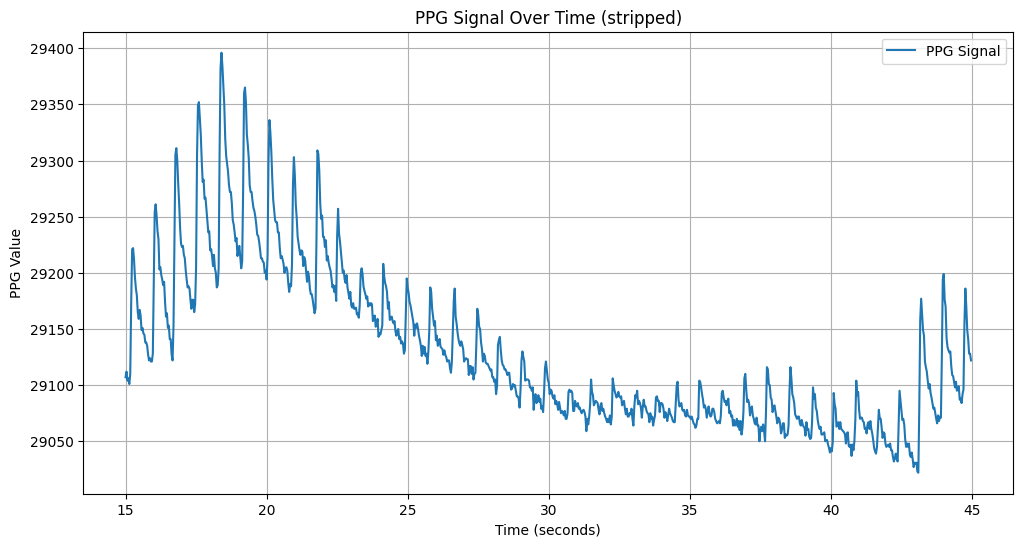

In [51]:
stripped_data = data[samples_to_strip:samples_to_strip+sample_amount]
stripped_time = time[samples_to_strip:samples_to_strip+sample_amount]

plt.figure(figsize=(12, 6))
plt.plot(stripped_time, stripped_data, label='PPG Signal')
plt.xlabel('Time (seconds)')
plt.ylabel('PPG Value')
plt.title('PPG Signal Over Time (stripped)')
plt.legend()
plt.grid(True)
plt.show()

In [52]:
# Normalize the PPG data (subtract mean and divide by standard deviation)

# Calculate the mean and standard deviation of the PPG data
mean_data = np.mean(stripped_data)
std_data = np.std(stripped_data)

# Normalize the PPG data
normalized_data = (stripped_data - mean_data) #/ std_data   ...... not dividing by std_data to keep amplitude for now


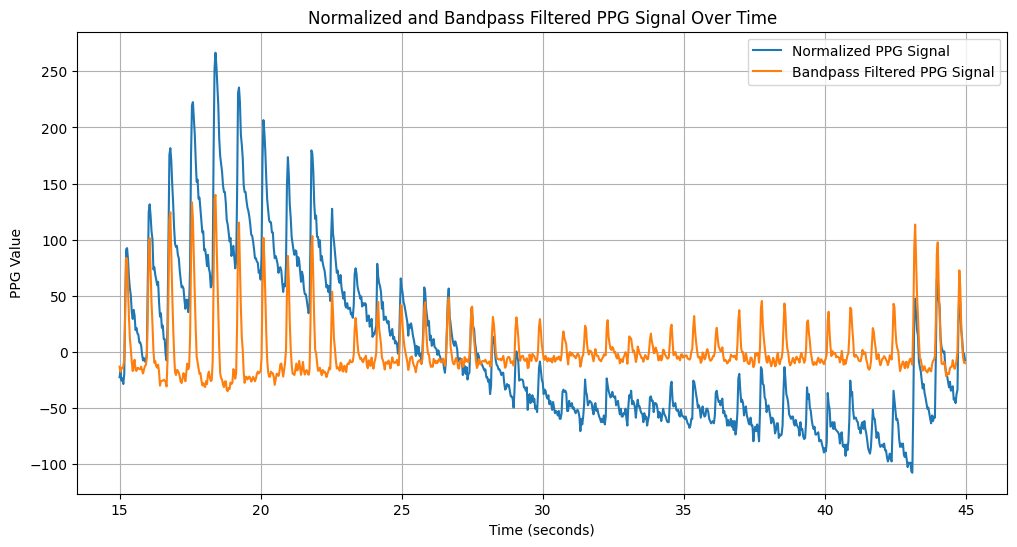

In [53]:
from scipy.signal import butter, lfilter

def butter_bandpass(lowcut, highcut, fs, order=5):
    return butter(order, [lowcut, highcut], fs=fs, btype='band')

def butter_bandpass_filter(data, lowcut, highcut, fs, order=5):
    b, a = butter_bandpass(lowcut, highcut, fs, order=order)
    y = lfilter(b, a, data)
    return y


lowcut = 1  
highcut = 10  
fs = 30.0  
order = 1 

filtered_data = butter_bandpass_filter(normalized_data, lowcut, highcut, fs, order=order)

plt.figure(figsize=(12, 6))
plt.plot(stripped_time, normalized_data, label='Normalized PPG Signal')
plt.plot(stripped_time, filtered_data, label='Bandpass Filtered PPG Signal')
plt.xlabel('Time (seconds)')
plt.ylabel('PPG Value')
plt.title('Normalized and Bandpass Filtered PPG Signal Over Time')
plt.legend()
plt.grid(True)
plt.show()


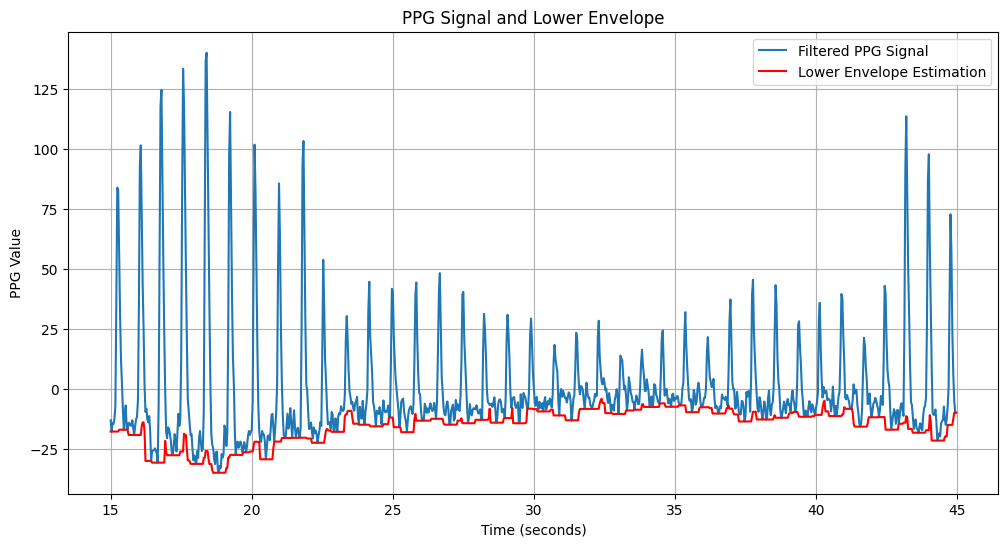

In [54]:
def minimum_filter(data, window_size):
    n = len(data)
    output = np.zeros(n)
    for i in range(n):
        start_index = max(i - window_size // 2, 0)
        end_index = min(i + window_size // 2, n)
        output[i] = np.min(data[start_index:end_index])
    return output

window_width = int(0.5 * fs)  # 0.5 seconds * 30 Hz

lower_envelope_est = minimum_filter(filtered_data, window_width)

plt.figure(figsize=(12, 6))
plt.plot(stripped_time, filtered_data, label='Filtered PPG Signal')
plt.plot(stripped_time, lower_envelope_est, label='Lower Envelope Estimation', color='red')
plt.xlabel('Time (seconds)')
plt.ylabel('PPG Value')
plt.title('PPG Signal and Lower Envelope')
plt.legend()
plt.grid(True)
plt.show()



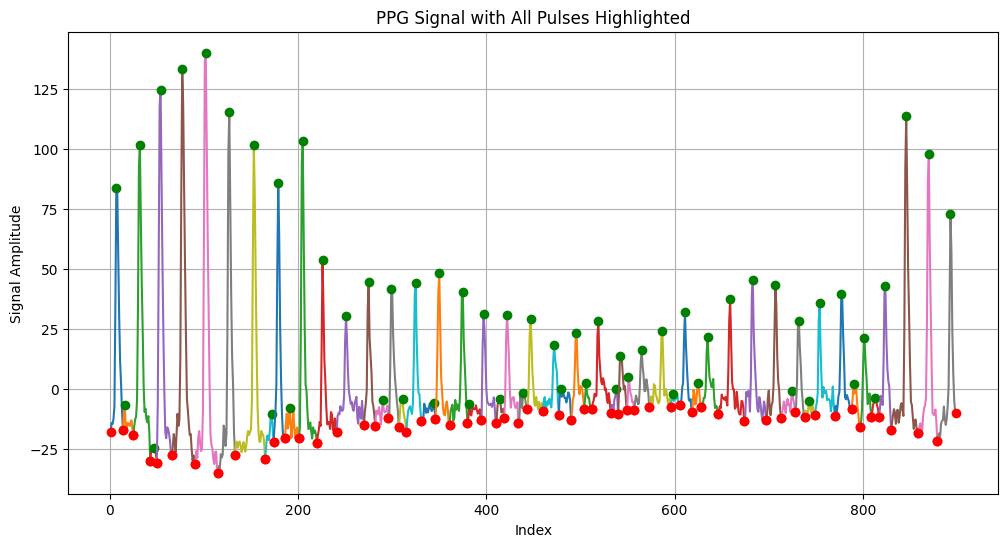

In [55]:
import numpy as np
import matplotlib.pyplot as plt

class Pulse:
    def __init__(self, signal, start_trough_index, peak_index, end_trough_index):
        self.signal = signal
        self.start_trough_index = start_trough_index
        self.peak_index = peak_index
        self.end_trough_index = end_trough_index
    
    def get_pulse_data(self):
        """Returns the slice of the signal for this pulse."""
        return self.signal[self.start_trough_index:self.end_trough_index + 1]

    def plot_pulse(self, ax):
        """Plot the pulse on the provided Axes object."""
        time_indices = range(self.start_trough_index, self.end_trough_index + 1)
        ax.plot(time_indices, self.get_pulse_data(), label=f'Pulse from {self.start_trough_index} to {self.end_trough_index}')
        ax.plot(self.peak_index, self.signal[self.peak_index], 'go')  # Mark the peak
        ax.plot([self.start_trough_index, self.end_trough_index], [self.signal[self.start_trough_index], self.signal[self.end_trough_index]], 'ro')  # Mark the troughs
        
    def amplitude(self):
        """Returns the amplitude of the pulse."""
        return self.signal[self.peak_index] - self.signal[self.start_trough_index]

    def trough_depth_difference(self):
        """Returns the depth difference between the end and start trough."""
        return self.signal[self.end_trough_index] - self.signal[self.start_trough_index]

    def relative_depth_difference(self):
        """Returns the relative depth difference between the end and start trough."""
        return self.trough_depth_difference() / self.signal[self.peak_index]

    def pulse_width(self, fs):
        """Returns the pulse width based on the sampling frequency."""
        return (self.end_trough_index - self.start_trough_index) / fs


def find_troughs_from_envelope(signal, envelope):
    # Identify troughs as points where the signal matches the lower envelope
    return np.where(signal == envelope)[0]

def find_peaks(signal, trough_indices):
    # Find the maximum (peak) value between consecutive troughs
    peak_indices = []
    for i in range(len(trough_indices) - 1):
        start, end = trough_indices[i], trough_indices[i + 1]
        peak_index = np.argmax(signal[start:end+1]) + start
        peak_indices.append(peak_index)
    return peak_indices

trough_indices = find_troughs_from_envelope(filtered_data, lower_envelope_est)
peak_indices = find_peaks(filtered_data, trough_indices)

fig, ax = plt.subplots(figsize=(12, 6))

pulses = [Pulse(filtered_data, trough_indices[i], peak_indices[i], trough_indices[i + 1]) for i in range(len(peak_indices))]
for pulse in pulses:
    pulse.plot_pulse(ax)

ax.set_xlabel('Index')
ax.set_ylabel('Signal Amplitude')
ax.set_title('PPG Signal with All Pulses Highlighted')
ax.grid(True)
plt.show()


In [56]:


amplitude_values = [pulse.amplitude() for pulse in pulses]
# TODO: Determine sensible thresholds for these values, these are just placeholders
amplitude_min_threshold = 10
amplitude_max_threshold = 2000

trough_depth_values = [pulse.relative_depth_difference() for pulse in pulses]
trough_depth_difference_min_threshold = -0.25 #  -25% of the amplitude value
trough_depth_difference_max_threshold = 0.25 # 25% of the amplitude value

pulse_width_values = [pulse.pulse_width(fs) for pulse in pulses]
pulse_width_min_threshold = 1/3 # 0.333 seconds / 180 bpm
pulse_width_max_threshold = 1.5 # 1.5 seconds / 40 bpm

amplitude_values, trough_depth_values, pulse_width_values


([101.51382367063782,
  10.092067494967829,
  120.49983389393756,
  5.226173917606456,
  155.11799819458764,
  160.85370762706376,
  171.10438565205422,
  150.12221416582813,
  129.09609817962547,
  18.9199712089242,
  107.43111028552629,
  12.43582631013755,
  123.46434486807897,
  76.13025875098518,
  48.136891431789884,
  59.49158382638728,
  10.773150920439717,
  53.582756314023015,
  11.869431753730998,
  62.275246587043,
  7.420221704564106,
  60.60991875329113,
  55.25852188492005,
  7.952224633214218,
  44.10204724638773,
  9.698119614421376,
  42.96388926496386,
  12.600865474368051,
  37.48054694786703,
  27.681888634441478,
  10.996704675901176,
  36.42584030282564,
  10.911781756451617,
  36.65608019101913,
  9.93304196547166,
  24.283831670496813,
  13.816566303707013,
  24.951401669917573,
  31.81361030214139,
  5.4425058442077425,
  38.78805928000481,
  12.218316548862399,
  29.148546513987274,
  47.458036125507675,
  58.97238276480895,
  55.90984827034934,
  11.26640992

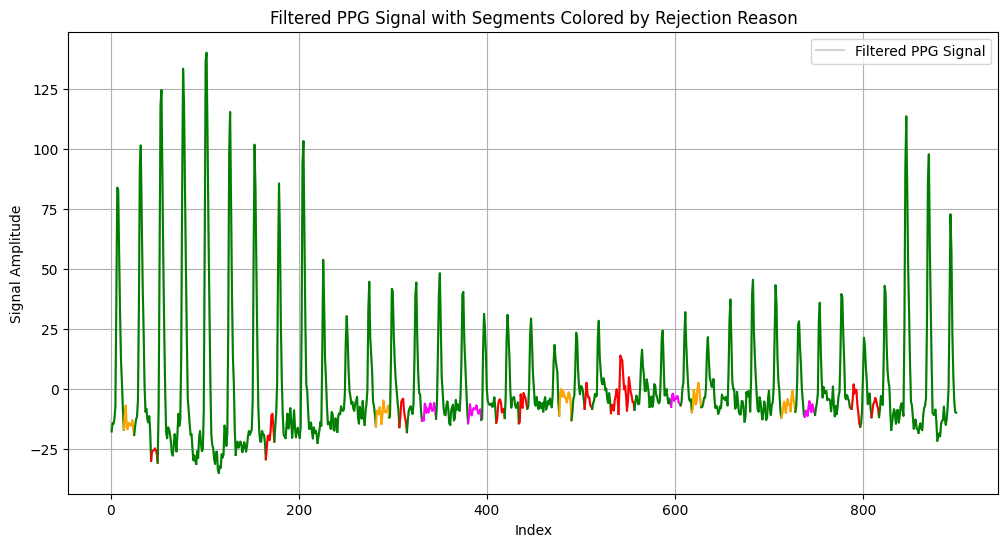

In [57]:
# Calculate the validity for each characteristic
amplitude_valid = [(amplitude_min_threshold <= value <= amplitude_max_threshold) for value in amplitude_values]
trough_depth_valid = [(trough_depth_difference_min_threshold <= value <= trough_depth_difference_max_threshold) for value in trough_depth_values]
pulse_width_valid = [(pulse_width_min_threshold <= value <= pulse_width_max_threshold) for value in pulse_width_values]

valid_indices = []
plt.figure(figsize=(12, 6))
plt.plot(filtered_data, label='Filtered PPG Signal', color='lightgray')

for i, pulse in enumerate(pulses):
    start, end = pulse.start_trough_index, pulse.end_trough_index
    valid = True  # Assume segment is valid unless a check fails

    # Check each condition
    if not pulse_width_valid[i]: # begin with pulse width, it's the strongest indicator
        segment_color = 'red'  # Pulse width invalid
        valid = False
    elif not amplitude_valid[i]:
        segment_color = 'magenta'  # Amplitude invalid
        valid = False
    elif not trough_depth_valid[i]:
        segment_color = 'orange'  # Trough depth invalid
        valid = False
    else:
        segment_color = 'green'  # Valid segment

    if valid:
        valid_indices.append(i)

    # Plot the pulse segment with the determined color
    plt.plot(range(start, end + 1), filtered_data[start:end + 1], color=segment_color)

plt.xlabel('Index')
plt.ylabel('Signal Amplitude')
plt.title('Filtered PPG Signal with Segments Colored by Rejection Reason')
plt.grid(True)
plt.legend()
plt.show()

/var/folders/yb/3195fdfn2vb_j67t_92p2yzw0000gn/T/ipykernel_87828/3596598324.py:33: RuntimeWarning: Mean of empty slice
  mean_pulse = np.nanmean(np.vstack(aligned_pulses), axis=0)


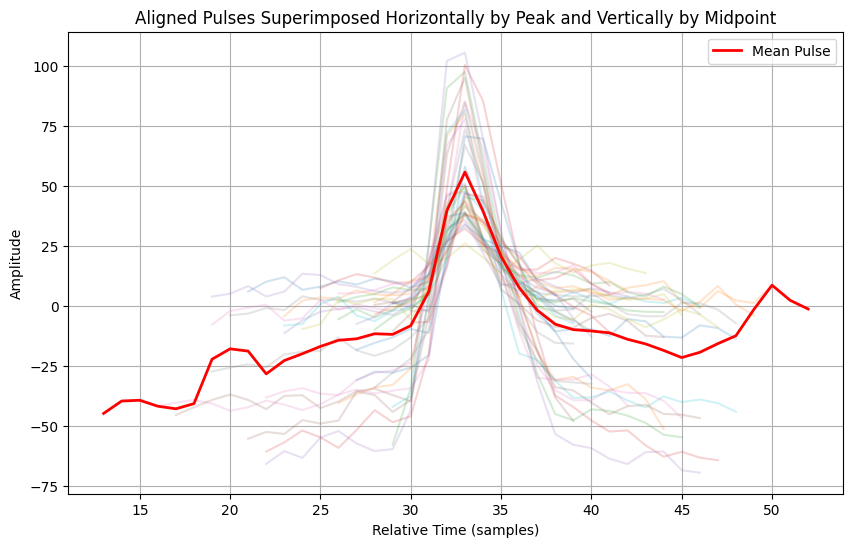

In [58]:
def align_pulses(pulses, fs):
    max_pulse_width = 0
    midpoints = []
    aligned_pulses = []
    vertical_offsets = []

    # Calculate necessary alignments and vertical offsets
    for pulse in pulses:
        pulse_data = pulse.get_pulse_data()
        pulse_length = len(pulse_data)
        midpoint_amplitude = (pulse.signal[pulse.peak_index] + pulse.signal[pulse.start_trough_index]) / 2
        max_pulse_width = max(max_pulse_width, pulse_length)
        midpoints.append(midpoint_amplitude)
    
    average_midpoint_amplitude = np.mean(midpoints)

    # Align all pulses horizontally and vertically
    for pulse in pulses:
        pulse_data = pulse.get_pulse_data()
        peak_position_in_pulse = pulse.peak_index - pulse.start_trough_index
        padding_before = max(max_pulse_width - peak_position_in_pulse, 0)
        offset_after = max(2 * max_pulse_width - (padding_before + len(pulse_data)), 0)
        aligned_pulse = np.pad(pulse_data, (padding_before, offset_after), 'constant', constant_values=(np.nan, np.nan))
        vertical_shift = average_midpoint_amplitude - (pulse.signal[pulse.peak_index] + pulse.signal[pulse.start_trough_index]) / 2
        aligned_pulse += vertical_shift
        aligned_pulses.append(aligned_pulse)
        vertical_offsets.append(vertical_shift)
    
    return aligned_pulses, vertical_offsets

valid_pulses = [pulses[i] for i in valid_indices]
aligned_pulses, y_offsets = align_pulses(valid_pulses, fs)
mean_pulse = np.nanmean(np.vstack(aligned_pulses), axis=0)


plt.figure(figsize=(10, 6))
for pulse in aligned_pulses:
    plt.plot(pulse, alpha=0.2) 

plt.plot(mean_pulse, color='red', linewidth=2, label='Mean Pulse')
plt.title('Aligned Pulses Superimposed Horizontally by Peak and Vertically by Midpoint')
plt.xlabel('Relative Time (samples)')
plt.ylabel('Amplitude')
plt.grid(True)
plt.legend()
plt.show()

[0.5814535010629127, 0.5470911022194053, 0.4294417049232435, 0.4298084864634124, 0.3856079551599803, 0.4969591621620031, 0.6520307983205916, 0.6347030630538022, 2.6757809253544695, 0.556062010729318, 1.0510556795105406, 1.621258100761798, 1.1950657737495463, 1.042073834214785, 1.2362293413725327, 1.1132049524797676, 1.3447278358741726, 1.5956079427881453, 1.6829798086013164, 1.8921610837977654, 2.534231157659321, 1.9958082010129854, 2.109311113049428, 2.9070304853964704, 2.22949001548397, 1.787025241176256, 2.377626000881169, 1.6185535735786414, 1.2894931112647328, 1.3463168639717793, 1.5779843547910304, 1.6002427759513975, 1.325332031540574, 1.774112005880158, 1.1445817774133658, 0.5951846678479793, 0.6185490574147744, 0.8678719250416629]


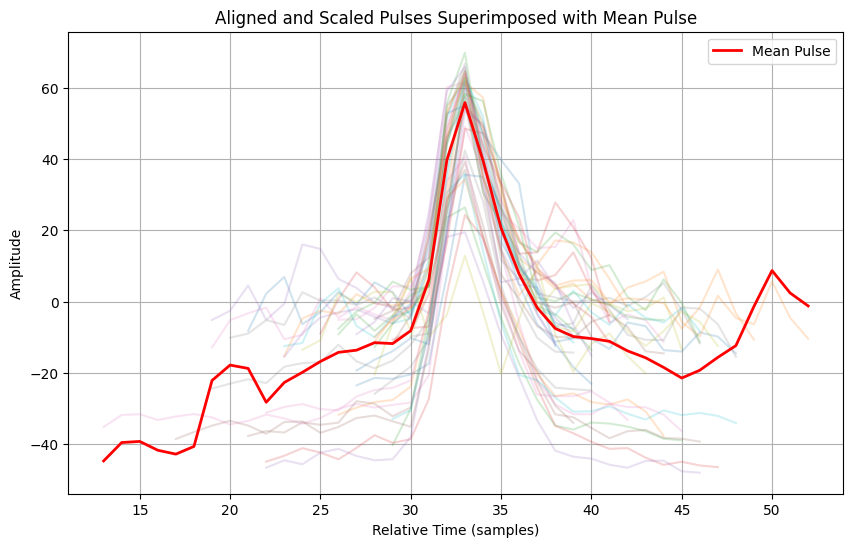

In [59]:
def scale_pulses_to_minimize_difference(pulses, y_offsets, mean_pulse):
    scaled_pulses = []
    scaling_factors = []

    for pulse, y_offset in zip(pulses, y_offsets):
        # Only consider non-NaN values for calculation
        valid_indices = ~np.isnan(pulse)
        valid_pulse = pulse[valid_indices]
        valid_mean_pulse = mean_pulse[valid_indices]

        std_valid_pulse = valid_pulse - np.mean(valid_pulse)
        std_valid_mean_pulse = valid_mean_pulse - np.mean(valid_mean_pulse)

        # Calculate the optimal scaling factor using the dot product
        # TODO: Explain why this is the optimal scaling factor
        scale_factor = np.dot(std_valid_pulse, std_valid_mean_pulse) / np.dot(std_valid_pulse, std_valid_pulse)
        scaled_pulses.append((pulse - y_offset) * scale_factor + y_offset)
        scaling_factors.append(scale_factor)

    return scaled_pulses, scaling_factors

scaled_pulses, scaling_factors = scale_pulses_to_minimize_difference(aligned_pulses, y_offsets, mean_pulse)

print(scaling_factors)

plt.figure(figsize=(10, 6))
for pulse, factor in zip(scaled_pulses, scaling_factors):
    plt.plot(pulse, alpha=0.2)

plt.plot(mean_pulse, color='red', linewidth=2, label='Mean Pulse')
plt.title('Aligned and Scaled Pulses Superimposed with Mean Pulse')
plt.xlabel('Relative Time (samples)')
plt.ylabel('Amplitude')
plt.legend()
plt.grid(True)
plt.show()

10.042565317735079
[11.17804466765764, 16.517132486809647, 22.943203447984587, 26.358986118622543, 28.87554367446458, 17.796337071591648, 14.000223638578692, 14.735852028368681, 16.306929652895022, 18.644679523377636, 5.3800637084366745, 10.82730805830759, 3.6589684497447075, 9.075310285318022, 7.895147613187815, 5.331681939218679, 10.407528174547908, 10.364016010801933, 8.880971862405776, 7.922277527042687, 13.254749608166886, 12.902767990846773, 14.097217793141324, 13.873804227757946, 15.408286019747237, 5.991464143131692, 11.628462401135337, 10.256531941834869, 7.458195201471638, 6.48476865594978, 5.074087047425119, 11.10947819518923, 9.378889313054033, 9.473396039548078, 8.368407881917097, 17.96004290801453, 14.565524772756362, 5.241613752950398]


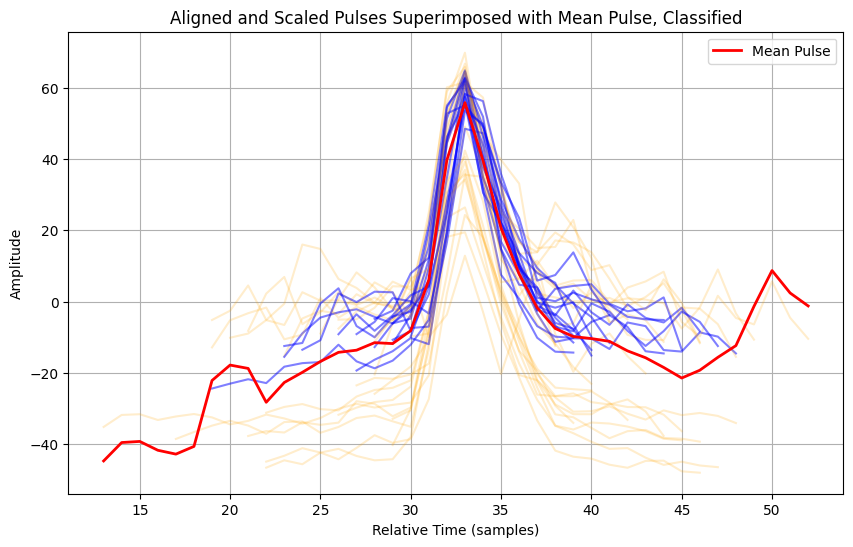

In [60]:
def classify_pulses(pulses, mean_pulse, threshold):
    classifications = []
    differences = []

    for pulse in pulses:
        # Calculate absolute difference from the mean pulse, ignoring NaNs
        valid_indices = ~np.isnan(pulse)
        difference = np.abs(pulse[valid_indices] - mean_pulse[valid_indices])
        mean_difference = np.mean(difference)

        if mean_difference <= threshold:
            classifications.append("Good")
        else:
            classifications.append("Bad")
        
        differences.append(mean_difference)

    return classifications, differences


non_nan_mean_pulse = mean_pulse[~np.isnan(mean_pulse)]
mean_amplitude = non_nan_mean_pulse[np.argmax(non_nan_mean_pulse)] - non_nan_mean_pulse[0]

difference_threshold = 0.1 * mean_amplitude # TODO: Is this a good threshold?

classifications, mean_differences = classify_pulses(scaled_pulses, mean_pulse, difference_threshold)

print(difference_threshold)
print(mean_differences)

plt.figure(figsize=(10, 6))
colors = {'Good': 'blue', 'Bad': 'orange'}
alpha_values = {'Good': 0.5, 'Bad': 0.2}
for pulse, classification in zip(scaled_pulses, classifications):
    plt.plot(pulse, alpha=alpha_values[classification], color=colors[classification])

plt.plot(mean_pulse, color='red', linewidth=2, label='Mean Pulse')
plt.title('Aligned and Scaled Pulses Superimposed with Mean Pulse, Classified')
plt.xlabel('Relative Time (samples)')
plt.ylabel('Amplitude')
plt.legend()
plt.grid(True)
plt.show()